In [1]:
import pandas as pd
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt
import collections
import seaborn as sns
import random
import matplotlib.colors as colors

In [2]:
def construct_graph_from_csv(edges_file, nodes_file):
    # Load edge data
    edge_df = pd.read_csv(edges_file)
    
    # Create a graph from the edge dataframe
    G = nx.from_pandas_edgelist(edge_df, 'Source', 'Target', 'Weight', create_using=nx.Graph())

    # Load node data
    node_df = pd.read_csv(nodes_file)
    
    # Create a dictionary in the form {node_id : {"Label": node_label}}
    node_dict = node_df.set_index('Id').to_dict('index')

    # Add node attributes to the graph
    nx.set_node_attributes(G, node_dict)

    return G

In [3]:
G = construct_graph_from_csv('CN_EN_CS_edges.csv', 'CN_EN_CS_nodes.csv')

In [4]:
def print_graph_info(G, n_sample_edges=5):
    """
    Print basic information about the graph G, such as number of nodes, number of edges,
    and the distribution of edge weights. Also, print n_sample_edges sample connections.
    """

    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")

    weights = [data["Weight"] for _, _, data in G.edges(data=True)]

    # Edge weights distribution plot
    sns.kdeplot(weights, fill=True)
    plt.title("Distribution of Edge Weights")
    plt.show()

    # Print n_sample_edges sample edges
    print(f"\n{n_sample_edges} sample connections:")
    sample_edges = random.sample(list(G.edges(data=True)), n_sample_edges)
    for u, v, data in sample_edges:
        print(f"Node {u} (Label: {G.nodes[u]['Label']}) - Node {v} (Label: {G.nodes[v]['Label']}), Weight: {data['Weight']}")


Number of nodes: 4062
Number of edges: 1030973


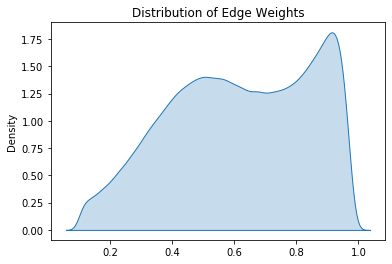


5 sample connections:
Node boyfriend (Label: en) - Node 随便 (Label: cn), Weight: 0.89717412
Node were (Label: en) - Node 好好 (Label: cn), Weight: 0.367075324
Node previous (Label: en) - Node 不久 (Label: cn), Weight: 0.8044333459999999
Node propose (Label: en) - Node one (Label: en), Weight: 0.155323476
Node 沟通 (Label: cn) - Node 讲 (Label: cn), Weight: 0.516965926


In [5]:
print_graph_info(G)

In [ ]:
partition = community_louvain.best_partition(G, weight='Weight')

In [ ]:
def plot_community_sizes(partition, G):
    # Compute the modularity
    modularity = community_louvain.modularity(partition, G)

    print(f"Modularity: {modularity}")

    # Count the number of nodes in each community
    community_sizes = {}
    community_labels = {}
    for node, community in partition.items():
        if community not in community_sizes:
            community_sizes[community] = 0
            community_labels[community] = {"en": 0, "cn": 0}
        
        community_sizes[community] += 1
        community_labels[community][G.nodes[node]['Label']] += 1

    # Print the label counts for each community and generate a pie chart
    for community, labels in community_labels.items():
        total = sum(labels.values())
        print(f"Community {community}:")
        sizes = []
        for label, count in labels.items():
            proportion = count / total * 100
            sizes.append(proportion)
            print(f"{label}: {count} ({proportion:.2f}%)")
        
        plt.pie(sizes, labels=labels.keys(), autopct='%1.1f%%')
        plt.title(f"Community {community} composition")
        plt.show()


def visualize_network(partition, G, pos=None):
    # Compute ForceAtlas2 layout for visualization 
    if pos is None:
        forceatlas2 = ForceAtlas2(
            # Behavior alternatives
            outboundAttractionDistribution=True,  # Dissuade hubs
            linLogMode=False,  # NOT IMPLEMENTED
            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
            edgeWeightInfluence=1.0,

            # Performance
            jitterTolerance=1.0,  # Tolerance
            barnesHutOptimize=True,
            barnesHutTheta=1.2,
            multiThreaded=False,  # NOT IMPLEMENTED

            # Tuning
            scalingRatio=2.0,
            strongGravityMode=False,
            gravity=1,

            # Log
            verbose=True
        )

        pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=200)
    

    # Scale position values to the range [0, 1] for better visualization
    scaler = MinMaxScaler()
    # Convert the positions into a 2D array suitable for scaler
    pos_array = np.array(list(pos.values()))
    # Fit the scaler and transform the positions
    pos_scaled_array = scaler.fit_transform(pos_array)
    # Convert the positions back into the dictionary format
    pos_scaled = {node: pos_scaled_array[i] for i, node in enumerate(pos.keys())}

    # Prepare node color list based on the 'Label' attribute
    color_map = {"en": "blue", "cn": "red"}
    node_colors = [color_map[G.nodes[node]['Label']] for node in G.nodes]

    # Draw the graph
    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(G, pos_scaled, node_size=5, node_color=node_colors, alpha=0.7)
    nx.draw_networkx_edges(G, pos_scaled, alpha=0.01, edge_color="lightgrey")

    plt.axis('off')
    plt.show()

In [ ]:
plot_community_sizes(partition, G)

In [ ]:
visualize_network(partition, G)